In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygame
import seaborn as sns
import random

# our classes
from agent import Agent, QLearningAgent
from environment import Environment
from screen import Screen

pygame 2.0.0 (SDL 2.0.12, python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


Configurações gerais para a execução dos modelos:

* O espaço de ações é denifido como uma matriz identidade 3x3
* Há três ações possíveis (continuar na mesma direção, virar para a esquerda, virar para a direita)
* Como cada estado é representado por um vetor binário de 11 posições, ao todo há 2^11 estados possíveis

In [2]:
# define environment
ACTION_SPACE = np.eye(3)
NUM_ACTIONS = 3
NUM_STATES = 2 ** 11

In [3]:
# Set options to activate or deactivate the game view, and its speed
pygame.font.init()

In [4]:
def plot_metrics(metrics, filepath=None):
    formatted_dict = {'episodes': [],
                      'metrics': [],
                      'results': []}

    n = len(metrics['episodes'])
    for i in range(n):
        episode = metrics['episodes'][i]
        score = metrics['scores'][i]
        reward = metrics['rewards'][i]

        formatted_dict['episodes'].append(episode)
        formatted_dict['metrics'].append('score')
        formatted_dict['results'].append(score)

        formatted_dict['episodes'].append(episode)
        formatted_dict['metrics'].append('reward')
        formatted_dict['results'].append(reward)

    df_metrics = pd.DataFrame(formatted_dict)
    sns.lineplot(data=df_metrics, x='episodes', y='results', hue='metrics')
    if filepath is None:
        plt.show()
    else:
        plt.savefig(filepath)


def decode_state(encoded_state):
    """
    Decode a binary representation of a state into its decimal base;
    
    encoded_state: an array of 0s and 1s representing a binary value
    
    return: decimal value
    """
    decoded = ''
    for s in encoded_state:
        decoded += str(s)

    return int(decoded, 2)


def decode_action(encoded_action):
    if isinstance(encoded_action, np.ndarray):
        return encoded_action.argmax()
    return encoded_action


A função de recompensa padrão é definida como:
    
* Ganha 10 pontos por comer a maçã
* Perde 10 pontos por morrer
* Recompensa 0 caso contrário

In [5]:
def default_reward(env):
    """
    Return the reward.
    The reward is:
        -10 when Snake crashes.
        +10 when Snake eats food
        0 otherwise
    """
    reward = 0
    if env.game.crash:
        reward = -10
    elif env.player.eaten:
        reward = 10

    return reward

# Q-Learning

In [6]:
def run_q_learning(agent: Agent, reward_function, episodes, display, speed, verbose=True):
    # setting random seed
    random.seed(42)
    np.random.seed(42)

    if display:
        pygame.init()

    env = Environment(440, 440, reward_function)
    screen = Screen(env)

    episode = 0
    metrics = {'episodes': [],
               'scores': [],
               'rewards': []}
    start = time.time()
    while episode < episodes:
        if display:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    quit()
                    
            screen.display()

        state1, done = env.reset()
        state1 = decode_state(state1)
        action1 = agent.choose_action(state1)
        episode_reward = 0
        while not done:
            # Getting the next state, reward
            state2, reward, done = env.step(action1)
            state2 = decode_state(state2)
            # Choosing the next action
            action2 = agent.choose_action(state2)

            # Learning the Q-value
            decoded_action1 = decode_action(action1)
            decoded_action2 = decode_action(action2)
            agent.update(state1, state2, reward, decoded_action1, decoded_action2)

            state1 = state2
            action1 = action2
            episode_reward += reward

            if display:
                screen.display()
                pygame.time.wait(speed)
            
            end = time.time()
            diff = end - start
            if diff > 600: # 10min
                break

        episode += 1
        if verbose:
            print(f'Game {episode}      Score: {env.game.score}')

        mean_reward = episode_reward/episodes
        metrics['episodes'].append(episode)
        metrics['rewards'].append(mean_reward)
        metrics['scores'].append(env.game.score)
        
        end = time.time()
        diff = end - start
        if diff > 600: # 10min
            break
        

    return metrics

### Experimento 1: Baseline

* N0 = 1
* gamma = 1
* número de episódios = 150

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 0
Game 4      Score: 1
Game 5      Score: 1
Game 6      Score: 2
Game 7      Score: 1
Game 8      Score: 0
Game 9      Score: 1
Game 10      Score: 1
Game 11      Score: 1
Game 12      Score: 1
Game 13      Score: 1
Game 14      Score: 1
Game 15      Score: 1
Game 16      Score: 1
Game 17      Score: 1
Game 18      Score: 1
Game 19      Score: 1
Game 20      Score: 2
Game 21      Score: 3
Game 22      Score: 2
Game 23      Score: 3
Game 24      Score: 2
Game 25      Score: 2
Game 26      Score: 2
Game 27      Score: 1
Game 28      Score: 1
Game 29      Score: 2
Game 30      Score: 2
Game 31      Score: 1
Game 32      Score: 1
Game 33      Score: 3
Game 34      Score: 3
Game 35      Score: 3
Game 36      Score: 4
Game 37      Score: 1
Game 38      Score: 3
Game 39      Score: 5
Game 40      Score: 9
Game 41      Score: 5
Game 42      Score: 2
Game 43      Score: 2
Game 44      Score: 1
Game 45      Score: 3
Game 46      Score:

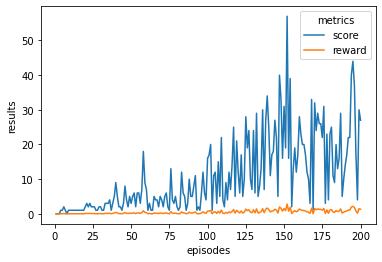

Run time: 86.7462990283966 seconds
Max. Score: 57


In [7]:
N0 = 1
gamma = 1

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=default_reward, episodes=200, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 0
Game 4      Score: 1
Game 5      Score: 1
Game 6      Score: 2
Game 7      Score: 1
Game 8      Score: 0
Game 9      Score: 1
Game 10      Score: 1
Game 11      Score: 1
Game 12      Score: 1
Game 13      Score: 1
Game 14      Score: 1
Game 15      Score: 1
Game 16      Score: 1
Game 17      Score: 1
Game 18      Score: 1
Game 19      Score: 1
Game 20      Score: 2
Game 21      Score: 3
Game 22      Score: 2
Game 23      Score: 3
Game 24      Score: 2
Game 25      Score: 2
Game 26      Score: 2
Game 27      Score: 1
Game 28      Score: 1
Game 29      Score: 2
Game 30      Score: 2
Game 31      Score: 1
Game 32      Score: 1
Game 33      Score: 3
Game 34      Score: 3
Game 35      Score: 3
Game 36      Score: 4
Game 37      Score: 1
Game 38      Score: 3
Game 39      Score: 5
Game 40      Score: 9
Game 41      Score: 5
Game 42      Score: 2
Game 43      Score: 2
Game 44      Score: 1
Game 45      Score: 3
Game 46      Score:

Game 353      Score: 31
Game 354      Score: 19
Game 355      Score: 30
Game 356      Score: 27
Game 357      Score: 23
Game 358      Score: 12
Game 359      Score: 16
Game 360      Score: 15
Game 361      Score: 31
Game 362      Score: 4
Game 363      Score: 11
Game 364      Score: 34
Game 365      Score: 5
Game 366      Score: 31
Game 367      Score: 27
Game 368      Score: 26
Game 369      Score: 27
Game 370      Score: 27
Game 371      Score: 23
Game 372      Score: 13
Game 373      Score: 34
Game 374      Score: 28
Game 375      Score: 22
Game 376      Score: 28
Game 377      Score: 24
Game 378      Score: 16
Game 379      Score: 6
Game 380      Score: 15
Game 381      Score: 31
Game 382      Score: 20
Game 383      Score: 34
Game 384      Score: 32
Game 385      Score: 31
Game 386      Score: 26
Game 387      Score: 31
Game 388      Score: 15
Game 389      Score: 14
Game 390      Score: 14
Game 391      Score: 19
Game 392      Score: 26
Game 393      Score: 22
Game 394      Score

Game 697      Score: 31
Game 698      Score: 15
Game 699      Score: 17
Game 700      Score: 16
Game 701      Score: 24
Game 702      Score: 17
Game 703      Score: 29
Game 704      Score: 40
Game 705      Score: 26
Game 706      Score: 36
Game 707      Score: 11
Game 708      Score: 12
Game 709      Score: 29
Game 710      Score: 20
Game 711      Score: 26
Game 712      Score: 19
Game 713      Score: 18
Game 714      Score: 24
Game 715      Score: 30
Game 716      Score: 23
Game 717      Score: 22
Game 718      Score: 19
Game 719      Score: 13
Game 720      Score: 21
Game 721      Score: 31
Game 722      Score: 19
Game 723      Score: 21
Game 724      Score: 24
Game 725      Score: 27
Game 726      Score: 14
Game 727      Score: 21
Game 728      Score: 27
Game 729      Score: 27
Game 730      Score: 12
Game 731      Score: 29
Game 732      Score: 20
Game 733      Score: 21
Game 734      Score: 25
Game 735      Score: 9
Game 736      Score: 18
Game 737      Score: 22
Game 738      Sco

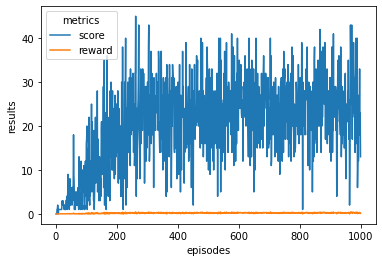

Run time: 166.78277158737183 seconds
Max. Score: 45


In [8]:
N0 = 1
gamma = 0.99

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 0
Game 4      Score: 1
Game 5      Score: 1
Game 6      Score: 2
Game 7      Score: 1
Game 8      Score: 0
Game 9      Score: 1
Game 10      Score: 1
Game 11      Score: 1
Game 12      Score: 1
Game 13      Score: 1
Game 14      Score: 1
Game 15      Score: 1
Game 16      Score: 1
Game 17      Score: 1
Game 18      Score: 1
Game 19      Score: 1
Game 20      Score: 2
Game 21      Score: 3
Game 22      Score: 2
Game 23      Score: 3
Game 24      Score: 2
Game 25      Score: 2
Game 26      Score: 2
Game 27      Score: 1
Game 28      Score: 1
Game 29      Score: 2
Game 30      Score: 2
Game 31      Score: 1
Game 32      Score: 1
Game 33      Score: 3
Game 34      Score: 3
Game 35      Score: 3
Game 36      Score: 4
Game 37      Score: 1
Game 38      Score: 3
Game 39      Score: 5
Game 40      Score: 9
Game 41      Score: 5
Game 42      Score: 2
Game 43      Score: 2
Game 44      Score: 1
Game 45      Score: 3
Game 46      Score:

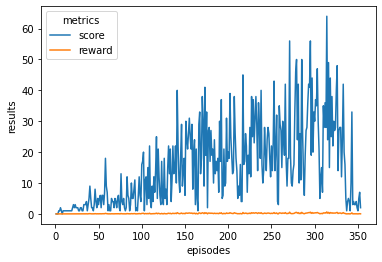

Run time: 600.0035691261292 seconds
Max. Score: 64


In [9]:
N0 = 1
gamma = 0.98

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 0
Game 4      Score: 1
Game 5      Score: 1
Game 6      Score: 2
Game 7      Score: 1
Game 8      Score: 0
Game 9      Score: 1
Game 10      Score: 1
Game 11      Score: 1
Game 12      Score: 1
Game 13      Score: 1
Game 14      Score: 1
Game 15      Score: 1
Game 16      Score: 1
Game 17      Score: 1
Game 18      Score: 1
Game 19      Score: 1
Game 20      Score: 2
Game 21      Score: 3
Game 22      Score: 2
Game 23      Score: 3
Game 24      Score: 2
Game 25      Score: 2
Game 26      Score: 2
Game 27      Score: 1
Game 28      Score: 1
Game 29      Score: 2
Game 30      Score: 2
Game 31      Score: 1
Game 32      Score: 1
Game 33      Score: 3
Game 34      Score: 3
Game 35      Score: 3
Game 36      Score: 4
Game 37      Score: 1
Game 38      Score: 3
Game 39      Score: 5
Game 40      Score: 9
Game 41      Score: 5
Game 42      Score: 2
Game 43      Score: 2
Game 44      Score: 1
Game 45      Score: 3
Game 46      Score:

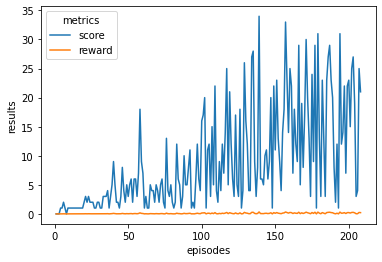

Run time: 600.0037281513214 seconds
Max. Score: 34


In [10]:
N0 = 1
gamma = 0.95

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Como no treinamento do modelo com ``gamma = 0.98`` o score apresenta uma tendência de crescimento que é maior que as demais, tomaremos 0.98 como o fator de desconto.

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 0
Game 4      Score: 1
Game 5      Score: 2
Game 6      Score: 1
Game 7      Score: 1
Game 8      Score: 1
Game 9      Score: 1
Game 10      Score: 1
Game 11      Score: 1
Game 12      Score: 1
Game 13      Score: 1
Game 14      Score: 1
Game 15      Score: 1
Game 16      Score: 1
Game 17      Score: 1
Game 18      Score: 1
Game 19      Score: 1
Game 20      Score: 1
Game 21      Score: 1
Game 22      Score: 1
Game 23      Score: 1
Game 24      Score: 3
Game 25      Score: 1
Game 26      Score: 4
Game 27      Score: 3
Game 28      Score: 5
Game 29      Score: 3
Game 30      Score: 5
Game 31      Score: 2
Game 32      Score: 5
Game 33      Score: 10
Game 34      Score: 18
Game 35      Score: 3
Game 36      Score: 7
Game 37      Score: 4
Game 38      Score: 11
Game 39      Score: 3
Game 40      Score: 6
Game 41      Score: 1
Game 42      Score: 3
Game 43      Score: 10
Game 44      Score: 6
Game 45      Score: 2
Game 46      Sc

Game 354      Score: 31
Game 355      Score: 54
Game 356      Score: 34
Game 357      Score: 15
Game 358      Score: 8
Game 359      Score: 25
Game 360      Score: 35
Game 361      Score: 47
Game 362      Score: 26
Game 363      Score: 55
Game 364      Score: 30
Game 365      Score: 22
Game 366      Score: 47
Game 367      Score: 27
Game 368      Score: 16
Game 369      Score: 32
Game 370      Score: 39
Game 371      Score: 41
Game 372      Score: 38
Game 373      Score: 31
Game 374      Score: 30
Game 375      Score: 36
Game 376      Score: 27
Game 377      Score: 32
Game 378      Score: 18
Game 379      Score: 51
Game 380      Score: 28
Game 381      Score: 21
Game 382      Score: 58
Game 383      Score: 26
Game 384      Score: 31
Game 385      Score: 35
Game 386      Score: 43
Game 387      Score: 47
Game 388      Score: 39
Game 389      Score: 57
Game 390      Score: 38
Game 391      Score: 30
Game 392      Score: 30
Game 393      Score: 34
Game 394      Score: 28
Game 395      Sco

Game 697      Score: 45
Game 698      Score: 24
Game 699      Score: 30
Game 700      Score: 40
Game 701      Score: 11
Game 702      Score: 38
Game 703      Score: 38
Game 704      Score: 35
Game 705      Score: 19
Game 706      Score: 28
Game 707      Score: 29
Game 708      Score: 51
Game 709      Score: 33
Game 710      Score: 33
Game 711      Score: 20
Game 712      Score: 26
Game 713      Score: 22
Game 714      Score: 14
Game 715      Score: 21
Game 716      Score: 19
Game 717      Score: 36
Game 718      Score: 18
Game 719      Score: 38
Game 720      Score: 45
Game 721      Score: 19
Game 722      Score: 10
Game 723      Score: 16
Game 724      Score: 43
Game 725      Score: 38
Game 726      Score: 40
Game 727      Score: 37
Game 728      Score: 29
Game 729      Score: 41
Game 730      Score: 17
Game 731      Score: 23
Game 732      Score: 14
Game 733      Score: 31
Game 734      Score: 14
Game 735      Score: 31
Game 736      Score: 27
Game 737      Score: 20
Game 738      Sc

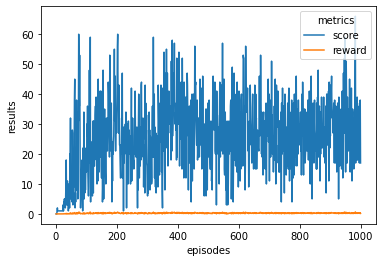

Run time: 44.54111289978027 seconds
Max. Score: 66


In [11]:
N0 = 0.75
gamma = 0.98

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 0
Game 4      Score: 0
Game 5      Score: 1
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 0
Game 9      Score: 0
Game 10      Score: 0
Game 11      Score: 0
Game 12      Score: 0
Game 13      Score: 0
Game 14      Score: 0
Game 15      Score: 0
Game 16      Score: 0
Game 17      Score: 0
Game 18      Score: 0
Game 19      Score: 0
Game 20      Score: 0
Game 21      Score: 0
Game 22      Score: 0
Game 23      Score: 0
Game 24      Score: 0
Game 25      Score: 0
Game 26      Score: 0
Game 27      Score: 0
Game 28      Score: 1
Game 29      Score: 0
Game 30      Score: 2
Game 31      Score: 0
Game 32      Score: 1
Game 33      Score: 0
Game 34      Score: 1
Game 35      Score: 0
Game 36      Score: 2
Game 37      Score: 4
Game 38      Score: 0
Game 39      Score: 2
Game 40      Score: 10
Game 41      Score: 2
Game 42      Score: 5
Game 43      Score: 4
Game 44      Score: 6
Game 45      Score: 2
Game 46      Score

Game 353      Score: 40
Game 354      Score: 33
Game 355      Score: 2
Game 356      Score: 27
Game 357      Score: 39
Game 358      Score: 31
Game 359      Score: 27
Game 360      Score: 23
Game 361      Score: 30
Game 362      Score: 30
Game 363      Score: 40
Game 364      Score: 23
Game 365      Score: 37
Game 366      Score: 26
Game 367      Score: 35
Game 368      Score: 14
Game 369      Score: 28
Game 370      Score: 22
Game 371      Score: 20
Game 372      Score: 36
Game 373      Score: 31
Game 374      Score: 45
Game 375      Score: 23
Game 376      Score: 43
Game 377      Score: 46
Game 378      Score: 44
Game 379      Score: 42
Game 380      Score: 20
Game 381      Score: 36
Game 382      Score: 33
Game 383      Score: 18
Game 384      Score: 39
Game 385      Score: 27
Game 386      Score: 31
Game 387      Score: 25
Game 388      Score: 30
Game 389      Score: 28
Game 390      Score: 30
Game 391      Score: 24
Game 392      Score: 33
Game 393      Score: 33
Game 394      Sco

Game 697      Score: 39
Game 698      Score: 30
Game 699      Score: 39
Game 700      Score: 57
Game 701      Score: 57
Game 702      Score: 41
Game 703      Score: 21
Game 704      Score: 26
Game 705      Score: 21
Game 706      Score: 36
Game 707      Score: 34
Game 708      Score: 31
Game 709      Score: 17
Game 710      Score: 41
Game 711      Score: 27
Game 712      Score: 33
Game 713      Score: 43
Game 714      Score: 36
Game 715      Score: 25
Game 716      Score: 26
Game 717      Score: 28
Game 718      Score: 21
Game 719      Score: 33
Game 720      Score: 26
Game 721      Score: 22
Game 722      Score: 26
Game 723      Score: 41
Game 724      Score: 37
Game 725      Score: 12
Game 726      Score: 36
Game 727      Score: 34
Game 728      Score: 33
Game 729      Score: 48
Game 730      Score: 40
Game 731      Score: 10
Game 732      Score: 20
Game 733      Score: 27
Game 734      Score: 34
Game 735      Score: 37
Game 736      Score: 30
Game 737      Score: 47
Game 738      Sc

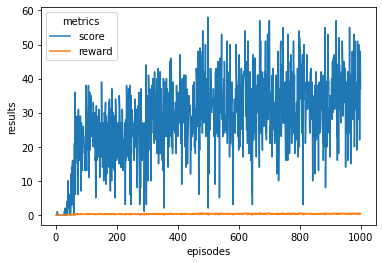

Run time: 58.652116775512695 seconds
Max. Score: 58


In [12]:
N0 = 0.5
gamma = 0.98

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 1
Game 3      Score: 0
Game 4      Score: 0
Game 5      Score: 0
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 0
Game 9      Score: 3
Game 10      Score: 0
Game 11      Score: 0
Game 12      Score: 3
Game 13      Score: 3
Game 14      Score: 3
Game 15      Score: 2
Game 16      Score: 0
Game 17      Score: 2
Game 18      Score: 4
Game 19      Score: 3
Game 20      Score: 2
Game 21      Score: 4
Game 22      Score: 4
Game 23      Score: 8
Game 24      Score: 5
Game 25      Score: 3
Game 26      Score: 13
Game 27      Score: 3
Game 28      Score: 8
Game 29      Score: 5
Game 30      Score: 7
Game 31      Score: 7
Game 32      Score: 7
Game 33      Score: 3
Game 34      Score: 3
Game 35      Score: 12
Game 36      Score: 2
Game 37      Score: 3
Game 38      Score: 8
Game 39      Score: 5
Game 40      Score: 7
Game 41      Score: 5
Game 42      Score: 3
Game 43      Score: 6
Game 44      Score: 9
Game 45      Score: 5
Game 46      Scor

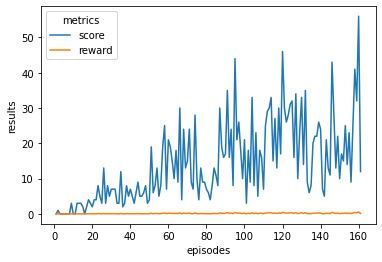

Run time: 600.0043959617615 seconds
Max. Score: 56


In [13]:
N0 = 0.25
gamma = 0.98

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 1
Game 3      Score: 0
Game 4      Score: 1
Game 5      Score: 0
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 1
Game 9      Score: 1
Game 10      Score: 1
Game 11      Score: 0
Game 12      Score: 0
Game 13      Score: 0
Game 14      Score: 3
Game 15      Score: 1
Game 16      Score: 1
Game 17      Score: 1
Game 18      Score: 0
Game 19      Score: 1
Game 20      Score: 3
Game 21      Score: 3
Game 22      Score: 1
Game 23      Score: 1
Game 24      Score: 4
Game 25      Score: 1
Game 26      Score: 1
Game 27      Score: 1
Game 28      Score: 0
Game 29      Score: 1
Game 30      Score: 4
Game 31      Score: 2
Game 32      Score: 1
Game 33      Score: 1
Game 34      Score: 1
Game 35      Score: 5
Game 36      Score: 1
Game 37      Score: 1
Game 38      Score: 1
Game 39      Score: 2
Game 40      Score: 2
Game 41      Score: 2
Game 42      Score: 0
Game 43      Score: 4
Game 44      Score: 1
Game 45      Score: 4
Game 46      Score:

Game 363      Score: 16
Game 364      Score: 12
Game 365      Score: 11
Game 366      Score: 22
Game 367      Score: 14
Game 368      Score: 6
Game 369      Score: 5
Game 370      Score: 15
Game 371      Score: 8
Game 372      Score: 15
Game 373      Score: 24
Game 374      Score: 22
Game 375      Score: 11
Game 376      Score: 8
Game 377      Score: 13
Game 378      Score: 24
Game 379      Score: 19
Game 380      Score: 36
Game 381      Score: 19
Game 382      Score: 14
Game 383      Score: 12
Game 384      Score: 22
Game 385      Score: 14
Game 386      Score: 19
Game 387      Score: 25
Game 388      Score: 20
Game 389      Score: 11
Game 390      Score: 10
Game 391      Score: 12
Game 392      Score: 34
Game 393      Score: 16
Game 394      Score: 16
Game 395      Score: 9
Game 396      Score: 10
Game 397      Score: 15
Game 398      Score: 19
Game 399      Score: 15
Game 400      Score: 9
Game 401      Score: 23
Game 402      Score: 27
Game 403      Score: 31
Game 404      Score: 1

Game 708      Score: 36
Game 709      Score: 19
Game 710      Score: 33
Game 711      Score: 1
Game 712      Score: 25
Game 713      Score: 30
Game 714      Score: 19
Game 715      Score: 31
Game 716      Score: 29
Game 717      Score: 24
Game 718      Score: 27
Game 719      Score: 32
Game 720      Score: 23
Game 721      Score: 16
Game 722      Score: 28
Game 723      Score: 14
Game 724      Score: 36
Game 725      Score: 13
Game 726      Score: 17
Game 727      Score: 38
Game 728      Score: 26
Game 729      Score: 11
Game 730      Score: 35
Game 731      Score: 34
Game 732      Score: 18
Game 733      Score: 37
Game 734      Score: 6
Game 735      Score: 24
Game 736      Score: 39
Game 737      Score: 14
Game 738      Score: 5
Game 739      Score: 23
Game 740      Score: 18
Game 741      Score: 28
Game 742      Score: 25
Game 743      Score: 25
Game 744      Score: 20
Game 745      Score: 19
Game 746      Score: 35
Game 747      Score: 19
Game 748      Score: 25
Game 749      Score

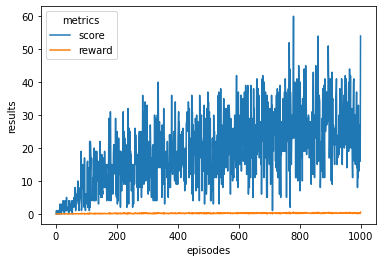

Run time: 25.89958643913269 seconds
Max. Score: 60


In [14]:
N0 = 2
gamma = 0.98

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 0
Game 4      Score: 0
Game 5      Score: 0
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 1
Game 9      Score: 0
Game 10      Score: 0
Game 11      Score: 2
Game 12      Score: 0
Game 13      Score: 1
Game 14      Score: 1
Game 15      Score: 1
Game 16      Score: 0
Game 17      Score: 0
Game 18      Score: 1
Game 19      Score: 1
Game 20      Score: 0
Game 21      Score: 1
Game 22      Score: 0
Game 23      Score: 1
Game 24      Score: 1
Game 25      Score: 1
Game 26      Score: 0
Game 27      Score: 0
Game 28      Score: 1
Game 29      Score: 1
Game 30      Score: 1
Game 31      Score: 1
Game 32      Score: 1
Game 33      Score: 1
Game 34      Score: 1
Game 35      Score: 1
Game 36      Score: 1
Game 37      Score: 1
Game 38      Score: 3
Game 39      Score: 1
Game 40      Score: 2
Game 41      Score: 2
Game 42      Score: 1
Game 43      Score: 2
Game 44      Score: 0
Game 45      Score: 2
Game 46      Score:

Game 356      Score: 12
Game 357      Score: 10
Game 358      Score: 12
Game 359      Score: 22
Game 360      Score: 5
Game 361      Score: 9
Game 362      Score: 16
Game 363      Score: 3
Game 364      Score: 14
Game 365      Score: 22
Game 366      Score: 20
Game 367      Score: 18
Game 368      Score: 15
Game 369      Score: 9
Game 370      Score: 14
Game 371      Score: 16
Game 372      Score: 10
Game 373      Score: 21
Game 374      Score: 23
Game 375      Score: 8
Game 376      Score: 20
Game 377      Score: 10
Game 378      Score: 12
Game 379      Score: 17
Game 380      Score: 18
Game 381      Score: 12
Game 382      Score: 15
Game 383      Score: 22
Game 384      Score: 27
Game 385      Score: 11
Game 386      Score: 4
Game 387      Score: 18
Game 388      Score: 11
Game 389      Score: 17
Game 390      Score: 18
Game 391      Score: 19
Game 392      Score: 15
Game 393      Score: 21
Game 394      Score: 23
Game 395      Score: 8
Game 396      Score: 10
Game 397      Score: 30

Game 706      Score: 23
Game 707      Score: 13
Game 708      Score: 26
Game 709      Score: 30
Game 710      Score: 29
Game 711      Score: 26
Game 712      Score: 11
Game 713      Score: 22
Game 714      Score: 20
Game 715      Score: 16
Game 716      Score: 26
Game 717      Score: 15
Game 718      Score: 35
Game 719      Score: 4
Game 720      Score: 46
Game 721      Score: 20
Game 722      Score: 10
Game 723      Score: 21
Game 724      Score: 24
Game 725      Score: 27
Game 726      Score: 19
Game 727      Score: 29
Game 728      Score: 30
Game 729      Score: 29
Game 730      Score: 23
Game 731      Score: 16
Game 732      Score: 26
Game 733      Score: 16
Game 734      Score: 17
Game 735      Score: 9
Game 736      Score: 22
Game 737      Score: 10
Game 738      Score: 43
Game 739      Score: 16
Game 740      Score: 34
Game 741      Score: 28
Game 742      Score: 30
Game 743      Score: 23
Game 744      Score: 16
Game 745      Score: 35
Game 746      Score: 33
Game 747      Scor

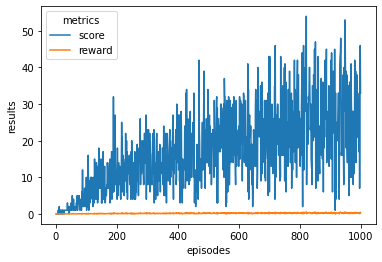

Run time: 21.196118593215942 seconds
Max. Score: 54


In [15]:
N0 = 4
gamma = 0.98

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 0
Game 2      Score: 1
Game 3      Score: 0
Game 4      Score: 0
Game 5      Score: 0
Game 6      Score: 1
Game 7      Score: 1
Game 8      Score: 1
Game 9      Score: 1
Game 10      Score: 2
Game 11      Score: 1
Game 12      Score: 0
Game 13      Score: 1
Game 14      Score: 1
Game 15      Score: 0
Game 16      Score: 2
Game 17      Score: 1
Game 18      Score: 2
Game 19      Score: 1
Game 20      Score: 1
Game 21      Score: 2
Game 22      Score: 1
Game 23      Score: 1
Game 24      Score: 3
Game 25      Score: 3
Game 26      Score: 0
Game 27      Score: 1
Game 28      Score: 3
Game 29      Score: 1
Game 30      Score: 1
Game 31      Score: 2
Game 32      Score: 1
Game 33      Score: 2
Game 34      Score: 1
Game 35      Score: 1
Game 36      Score: 2
Game 37      Score: 1
Game 38      Score: 2
Game 39      Score: 3
Game 40      Score: 2
Game 41      Score: 1
Game 42      Score: 2
Game 43      Score: 3
Game 44      Score: 2
Game 45      Score: 3
Game 46      Score:

Game 359      Score: 16
Game 360      Score: 10
Game 361      Score: 16
Game 362      Score: 19
Game 363      Score: 5
Game 364      Score: 13
Game 365      Score: 12
Game 366      Score: 10
Game 367      Score: 10
Game 368      Score: 4
Game 369      Score: 11
Game 370      Score: 8
Game 371      Score: 23
Game 372      Score: 14
Game 373      Score: 4
Game 374      Score: 22
Game 375      Score: 20
Game 376      Score: 9
Game 377      Score: 24
Game 378      Score: 7
Game 379      Score: 4
Game 380      Score: 12
Game 381      Score: 4
Game 382      Score: 9
Game 383      Score: 3
Game 384      Score: 13
Game 385      Score: 12
Game 386      Score: 12
Game 387      Score: 19
Game 388      Score: 5
Game 389      Score: 13
Game 390      Score: 3
Game 391      Score: 7
Game 392      Score: 17
Game 393      Score: 12
Game 394      Score: 4
Game 395      Score: 7
Game 396      Score: 7
Game 397      Score: 11
Game 398      Score: 17
Game 399      Score: 8
Game 400      Score: 19
Game 401 

Game 709      Score: 20
Game 710      Score: 13
Game 711      Score: 14
Game 712      Score: 27
Game 713      Score: 10
Game 714      Score: 9
Game 715      Score: 3
Game 716      Score: 21
Game 717      Score: 13
Game 718      Score: 16
Game 719      Score: 4
Game 720      Score: 20
Game 721      Score: 17
Game 722      Score: 22
Game 723      Score: 17
Game 724      Score: 6
Game 725      Score: 6
Game 726      Score: 25
Game 727      Score: 20
Game 728      Score: 17
Game 729      Score: 11
Game 730      Score: 15
Game 731      Score: 15
Game 732      Score: 7
Game 733      Score: 12
Game 734      Score: 9
Game 735      Score: 14
Game 736      Score: 20
Game 737      Score: 16
Game 738      Score: 18
Game 739      Score: 10
Game 740      Score: 10
Game 741      Score: 8
Game 742      Score: 13
Game 743      Score: 14
Game 744      Score: 19
Game 745      Score: 19
Game 746      Score: 9
Game 747      Score: 21
Game 748      Score: 7
Game 749      Score: 34
Game 750      Score: 12
Ga

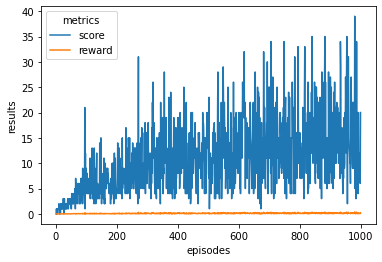

Run time: 14.676084280014038 seconds
Max. Score: 39


In [16]:
N0 = 10
gamma = 0.98

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=default_reward, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

### Experimento 3: Variando a função de recompensa


Game 1      Score: 2
Game 2      Score: 1
Game 3      Score: 5
Game 4      Score: 4
Game 5      Score: 1
Game 6      Score: 3
Game 7      Score: 3
Game 8      Score: 1
Game 9      Score: 3
Game 10      Score: 2
Game 11      Score: 10
Game 12      Score: 6
Game 13      Score: 4
Game 14      Score: 2
Game 15      Score: 5
Game 16      Score: 6
Game 17      Score: 2
Game 18      Score: 2
Game 19      Score: 7
Game 20      Score: 6
Game 21      Score: 6
Game 22      Score: 6
Game 23      Score: 6
Game 24      Score: 6
Game 25      Score: 4
Game 26      Score: 7
Game 27      Score: 6
Game 28      Score: 9
Game 29      Score: 4
Game 30      Score: 6
Game 31      Score: 3
Game 32      Score: 5
Game 33      Score: 4
Game 34      Score: 9
Game 35      Score: 3
Game 36      Score: 7
Game 37      Score: 8
Game 38      Score: 6
Game 39      Score: 6
Game 40      Score: 4
Game 41      Score: 11
Game 42      Score: 12
Game 43      Score: 11
Game 44      Score: 14
Game 45      Score: 13
Game 46      

Game 351      Score: 8
Game 352      Score: 42
Game 353      Score: 35
Game 354      Score: 18
Game 355      Score: 25
Game 356      Score: 10
Game 357      Score: 30
Game 358      Score: 23
Game 359      Score: 30
Game 360      Score: 48
Game 361      Score: 22
Game 362      Score: 24
Game 363      Score: 37
Game 364      Score: 29
Game 365      Score: 46
Game 366      Score: 23
Game 367      Score: 23
Game 368      Score: 16
Game 369      Score: 22
Game 370      Score: 24
Game 371      Score: 33
Game 372      Score: 36
Game 373      Score: 31
Game 374      Score: 34
Game 375      Score: 4
Game 376      Score: 18
Game 377      Score: 25
Game 378      Score: 21
Game 379      Score: 49
Game 380      Score: 32
Game 381      Score: 50
Game 382      Score: 19
Game 383      Score: 43
Game 384      Score: 37
Game 385      Score: 33
Game 386      Score: 35
Game 387      Score: 42
Game 388      Score: 23
Game 389      Score: 28
Game 390      Score: 30
Game 391      Score: 44
Game 392      Scor

Game 697      Score: 11
Game 698      Score: 43
Game 699      Score: 7
Game 700      Score: 41
Game 701      Score: 40
Game 702      Score: 24
Game 703      Score: 30
Game 704      Score: 64
Game 705      Score: 37
Game 706      Score: 19
Game 707      Score: 23
Game 708      Score: 32
Game 709      Score: 28
Game 710      Score: 32
Game 711      Score: 29
Game 712      Score: 58
Game 713      Score: 38
Game 714      Score: 38
Game 715      Score: 20
Game 716      Score: 31
Game 717      Score: 34
Game 718      Score: 19
Game 719      Score: 45
Game 720      Score: 37
Game 721      Score: 31
Game 722      Score: 35
Game 723      Score: 32
Game 724      Score: 25
Game 725      Score: 28
Game 726      Score: 41
Game 727      Score: 43
Game 728      Score: 12
Game 729      Score: 25
Game 730      Score: 29
Game 731      Score: 34
Game 732      Score: 40
Game 733      Score: 44
Game 734      Score: 28
Game 735      Score: 26
Game 736      Score: 38
Game 737      Score: 29
Game 738      Sco

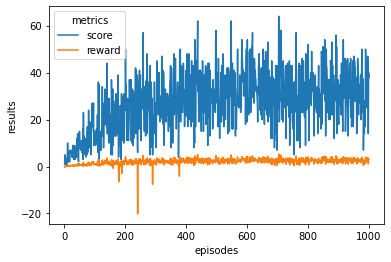

Run time: 42.418917179107666 seconds
Max. Score: 64


In [17]:
def reward1(env):
    """
    Return the reward.
    The reward is:
        -100 when Snake crashes.
        +100 when Snake eats food
        -1 otherwise
    """
    reward = -1
    if env.game.crash:
        reward = -100
    elif env.player.eaten:
        reward = 100

    return reward
    

N0 = 0.5
gamma = 0.98

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=reward1, episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

In [18]:
import math
from scipy.spatial.distance import cityblock

def reward_exp(env, max_value, max_dist=3, dist_metric=cityblock):
    """
    Return the reward.
    The reward is:
        -100 when Snake crashes.
        +100 when Snake eats food
        +max_value * exp(dist[snake, food]) if dist[snake, food] <= max_dist
        -0.01*non_improvement otherwise
    """
    global non_improvement
    
    player_pos = [env.player.x, env.player.y]
    food_pos = [env.food.x_food, env.food.y_food]
    dist = dist_metric(player_pos, player_pos)
    
    reward = max_value * math.exp(dist)
    if env.game.crash:
        reward = -1000
    elif env.player.eaten:
        reward = 1000
        non_improvement = 0
    elif dist >= max_dist:
        reward = -non_improvement*0.01
        non_improvement += 1

    return reward

Game 1      Score: 0
Game 2      Score: 0
Game 3      Score: 0
Game 4      Score: 0
Game 5      Score: 0
Game 6      Score: 0
Game 7      Score: 0
Game 8      Score: 1
Game 9      Score: 0
Game 10      Score: 0
Game 11      Score: 1
Game 12      Score: 1
Game 13      Score: 1
Game 14      Score: 1
Game 15      Score: 1
Game 16      Score: 1
Game 17      Score: 1
Game 18      Score: 1
Game 19      Score: 1
Game 20      Score: 1
Game 21      Score: 1
Game 22      Score: 1
Game 23      Score: 1
Game 24      Score: 1
Game 25      Score: 1
Game 26      Score: 1
Game 27      Score: 1
Game 28      Score: 1
Game 29      Score: 2
Game 30      Score: 1
Game 31      Score: 2
Game 32      Score: 2
Game 33      Score: 1
Game 34      Score: 1
Game 35      Score: 3
Game 36      Score: 3
Game 37      Score: 1
Game 38      Score: 1
Game 39      Score: 1
Game 40      Score: 2
Game 41      Score: 2
Game 42      Score: 3
Game 43      Score: 3
Game 44      Score: 3
Game 45      Score: 1
Game 46      Score:

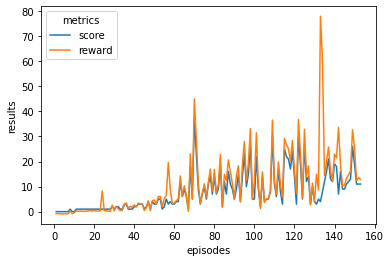

Run time: 600.4343683719635 seconds
Max. Score: 37


In [19]:
N0 = 0.5
gamma = 0.98
non_improvement = 0

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=lambda env: reward_exp(env, max_value=10),
                         episodes=1000, speed=1, display=True)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

In [23]:
import math
from scipy.spatial.distance import cityblock

def reward_linear(env, penalty_rate=0.01, dist_metric=cityblock):
    """
    Return the reward.
    The reward is:
        -100 when Snake crashes.
        +100 when Snake eats food
        -0.01*non_improvement otherwise
    """
    global non_improvement
    reward = -non_improvement*penalty_rate
    if env.game.crash:
        reward = -100
    elif env.player.eaten:
        reward = 100
        non_improvement = 0
    else:
        non_improvement += 1

    return reward

In [ ]:
N0 = 0.5
gamma = 0.98
non_improvement = 0

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=reward_linear,
                         episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))

Game 1      Score: 1
Game 2      Score: 1
Game 3      Score: 1
Game 4      Score: 0
Game 5      Score: 2
Game 6      Score: 1
Game 7      Score: 0
Game 8      Score: 1
Game 9      Score: 1
Game 10      Score: 1
Game 11      Score: 1
Game 12      Score: 1
Game 13      Score: 1
Game 14      Score: 3
Game 15      Score: 1
Game 16      Score: 1
Game 17      Score: 3
Game 18      Score: 3
Game 19      Score: 1
Game 20      Score: 1
Game 21      Score: 1
Game 22      Score: 1
Game 23      Score: 1
Game 24      Score: 3
Game 25      Score: 2
Game 26      Score: 3
Game 27      Score: 3
Game 28      Score: 2
Game 29      Score: 1
Game 30      Score: 1
Game 31      Score: 3
Game 32      Score: 1
Game 33      Score: 2
Game 34      Score: 7
Game 35      Score: 1
Game 36      Score: 1
Game 37      Score: 3
Game 38      Score: 6
Game 39      Score: 1
Game 40      Score: 4
Game 41      Score: 3
Game 42      Score: 4
Game 43      Score: 8
Game 44      Score: 14
Game 45      Score: 8
Game 46      Score

Game 354      Score: 29
Game 355      Score: 30
Game 356      Score: 46
Game 357      Score: 39
Game 358      Score: 40
Game 359      Score: 46
Game 360      Score: 22
Game 361      Score: 9
Game 362      Score: 41
Game 363      Score: 29
Game 364      Score: 47
Game 365      Score: 25
Game 366      Score: 19
Game 367      Score: 11
Game 368      Score: 13
Game 369      Score: 13
Game 370      Score: 11
Game 371      Score: 65
Game 372      Score: 38
Game 373      Score: 33
Game 374      Score: 20
Game 375      Score: 40
Game 376      Score: 10
Game 377      Score: 43
Game 378      Score: 23
Game 379      Score: 15
Game 380      Score: 45
Game 381      Score: 44
Game 382      Score: 38
Game 383      Score: 16
Game 384      Score: 3
Game 385      Score: 14
Game 386      Score: 21
Game 387      Score: 30
Game 388      Score: 12
Game 389      Score: 43
Game 390      Score: 43
Game 391      Score: 10
Game 392      Score: 16
Game 393      Score: 49
Game 394      Score: 17
Game 395      Scor

Game 698      Score: 40
Game 699      Score: 21
Game 700      Score: 42
Game 701      Score: 36
Game 702      Score: 40
Game 703      Score: 24
Game 704      Score: 24
Game 705      Score: 47
Game 706      Score: 24
Game 707      Score: 69
Game 708      Score: 50
Game 709      Score: 42
Game 710      Score: 34
Game 711      Score: 55
Game 712      Score: 27
Game 713      Score: 59
Game 714      Score: 58
Game 715      Score: 41
Game 716      Score: 34
Game 717      Score: 35
Game 718      Score: 13
Game 719      Score: 22
Game 720      Score: 38
Game 721      Score: 18
Game 722      Score: 26
Game 723      Score: 50
Game 724      Score: 33
Game 725      Score: 16
Game 726      Score: 48
Game 727      Score: 21
Game 728      Score: 44
Game 729      Score: 10
Game 730      Score: 31
Game 731      Score: 32
Game 732      Score: 47
Game 733      Score: 32
Game 734      Score: 21
Game 735      Score: 41
Game 736      Score: 42
Game 737      Score: 39
Game 738      Score: 24
Game 739      Sc

Game 1      Score: 1
Game 2      Score: 1
Game 3      Score: 1
Game 4      Score: 0
Game 5      Score: 2
Game 6      Score: 1
Game 7      Score: 0
Game 8      Score: 1
Game 9      Score: 1
Game 10      Score: 1
Game 11      Score: 1
Game 12      Score: 1
Game 13      Score: 1
Game 14      Score: 3
Game 15      Score: 1
Game 16      Score: 2
Game 17      Score: 2
Game 18      Score: 1
Game 19      Score: 1
Game 20      Score: 1
Game 21      Score: 1
Game 22      Score: 3
Game 23      Score: 3
Game 24      Score: 2
Game 25      Score: 1
Game 26      Score: 2
Game 27      Score: 3
Game 28      Score: 2
Game 29      Score: 1
Game 30      Score: 2
Game 31      Score: 2
Game 32      Score: 1
Game 33      Score: 2
Game 34      Score: 2
Game 35      Score: 3
Game 36      Score: 5
Game 37      Score: 1
Game 38      Score: 2
Game 39      Score: 2
Game 40      Score: 1
Game 41      Score: 1
Game 42      Score: 4
Game 43      Score: 5
Game 44      Score: 9
Game 45      Score: 4
Game 46      Score:

Game 359      Score: 17
Game 360      Score: 19
Game 361      Score: 35
Game 362      Score: 19
Game 363      Score: 30
Game 364      Score: 25
Game 365      Score: 30
Game 366      Score: 23
Game 367      Score: 32
Game 368      Score: 31
Game 369      Score: 37
Game 370      Score: 19
Game 371      Score: 14
Game 372      Score: 38
Game 373      Score: 33
Game 374      Score: 23
Game 375      Score: 18
Game 376      Score: 37
Game 377      Score: 23
Game 378      Score: 39
Game 379      Score: 30
Game 380      Score: 38
Game 381      Score: 15
Game 382      Score: 35
Game 383      Score: 25
Game 384      Score: 2
Game 385      Score: 20
Game 386      Score: 26
Game 387      Score: 30
Game 388      Score: 6
Game 389      Score: 38
Game 390      Score: 15
Game 391      Score: 38
Game 392      Score: 29
Game 393      Score: 9
Game 394      Score: 34
Game 395      Score: 33
Game 396      Score: 17
Game 397      Score: 42
Game 398      Score: 39
Game 399      Score: 27
Game 400      Score

Game 703      Score: 30
Game 704      Score: 32
Game 705      Score: 21
Game 706      Score: 39
Game 707      Score: 30
Game 708      Score: 21
Game 709      Score: 10
Game 710      Score: 29
Game 711      Score: 5
Game 712      Score: 40
Game 713      Score: 26
Game 714      Score: 24
Game 715      Score: 36
Game 716      Score: 29
Game 717      Score: 33
Game 718      Score: 42
Game 719      Score: 10
Game 720      Score: 29
Game 721      Score: 28
Game 722      Score: 23
Game 723      Score: 28
Game 724      Score: 41
Game 725      Score: 25
Game 726      Score: 25
Game 727      Score: 37
Game 728      Score: 28
Game 729      Score: 35
Game 730      Score: 30
Game 731      Score: 27
Game 732      Score: 14
Game 733      Score: 25
Game 734      Score: 3
Game 735      Score: 24
Game 736      Score: 25
Game 737      Score: 30
Game 738      Score: 42
Game 739      Score: 20
Game 740      Score: 40
Game 741      Score: 38
Game 742      Score: 32
Game 743      Score: 23
Game 744      Scor

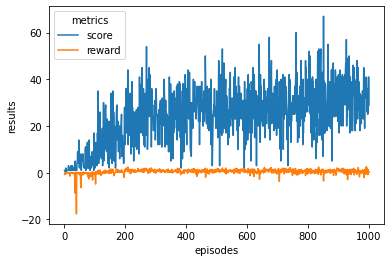

Run time: 41.371270418167114 seconds
Max. Score: 67
Mean Last Scores: 31.78


In [65]:
N0 = 0.5
gamma = 0.98
non_improvement = 0

# define agent
qLearningAgent = QLearningAgent(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_q_learning(qLearningAgent, reward_function=lambda env: reward_linear(env, penalty_rate=0.25),
                         episodes=1000, speed=0, display=False)
end = time.time()

plot_metrics(metrics, filepath=None)

print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))